## Пункты 1 и 2: иммитация движения КА по полярной орбите

В этом ноутбуке иммиттируется движение КА на один виток по полярной орбите с расчетом:
1. оптимального угла наклона солнечной панели
2. освещенности солнечной панели
3. кватерниона из орбитальной системы в собственную
4. кватерниона из инерциальной системы в собственную 

In [ ]:
#! pip install numpy
#! pip install scipy
#! pip install matplotlib
#! pip install pyquaternion

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from orientation_handler import SpacecraftOrientationHandler
from orbital_handler import OrbitalFrameOrientationHandler

In [28]:
def calc_inclunation(theta, raan):
    """
    Расчет наклонения полярной орбиты в инерциальной системе XYZ
    theta: угол между проекцией Земной оси на плоскость XY и направлением на Солнце (осью Х)
    raan: ДВУ орбиты в инерциальной системе
    """
    alpha = (90 - 23.44) / 180 * np.pi
    return np.pi / 2 - np.abs(np.arctan(np.sin(theta - raan) / np.tan(alpha)))

Задаем параметры плоскости орбиты КА и большую полуось (остальное определяется из того, что орбита круговая)

In [29]:
# Гравитационный параметер Земли 
mu = 398600.4415  # км^3 / c^2
# Радиус орбиты (большая полуось)
a = 6371 + 800    # км
# Долгта восходящего узла в инерциальной системе
Omega = np.pi / 4
# Наклонение полярной орбиты в инерциальной системе (нужно задать параметр theta, см. функцию выше)
i = calc_inclunation(theta=np.pi/2 , raan=Omega)

print("Наклонение орбиты: ", np.round(i * 180 / np.pi, 2), "градусов")
print("Долгота восходящего узла: ", np.round(Omega * 180 / np.pi, 2), "градусов")

Наклонение орбиты:  72.96 градусов
Долгота восходящего узла:  45.0 градусов


In [30]:
spacefraft_orientation = SpacecraftOrientationHandler(a, i, Omega, mu)
orbital_frame_orientation = OrbitalFrameOrientationHandler(a, i, Omega)

### Моделируем один виток
Один виток вокруг Земли --- это изменение аргумента широты от 0 до 2 $\pi$


In [31]:
discr_n = 500
u_s = np.linspace(0, 2 * np.pi, discr_n)

# угол между нормалью к панели и направлением на Солнце
phis = spacefraft_orientation.optimal_phi(u_s)
# освещенность панели на заданной ориентации
illuminance = spacefraft_orientation.illuminance(u_s, phis)
 # ориентация относительно орбитатальных осей
q_o2sc = np.array([spacefraft_orientation.orientation_in_orbital_frame(phi).elements for phi in phis])
 # ориентация относительно инерциальных осей
q_i2sc = np.array([(orbital_frame_orientation.orbital_frame_orientation(u) * 
          spacefraft_orientation.orientation_in_orbital_frame(phi)).elements for (u, phi) in zip(u_s, phis)])

In [ ]:
# Расчет области тени
with_shadow = True  # включить расчет областей тени (влияет на расчет освещенности и отрисовку графиков)
shadow = np.ones_like(u_s)
if with_shadow:
    shadow = orbital_frame_orientation.is_outside_the_dark(u_s)

# Найдем аргументы широты, где начинается и заканчивается область тени
u_shadow_starts = None
u_shadow_ends = None
try:
    u_shadow_starts = u_s[np.where(shadow == 0)[0][0]]
    u_shadow_ends = u_s[np.where(shadow == 0)[0][-1]]
except:
    pass


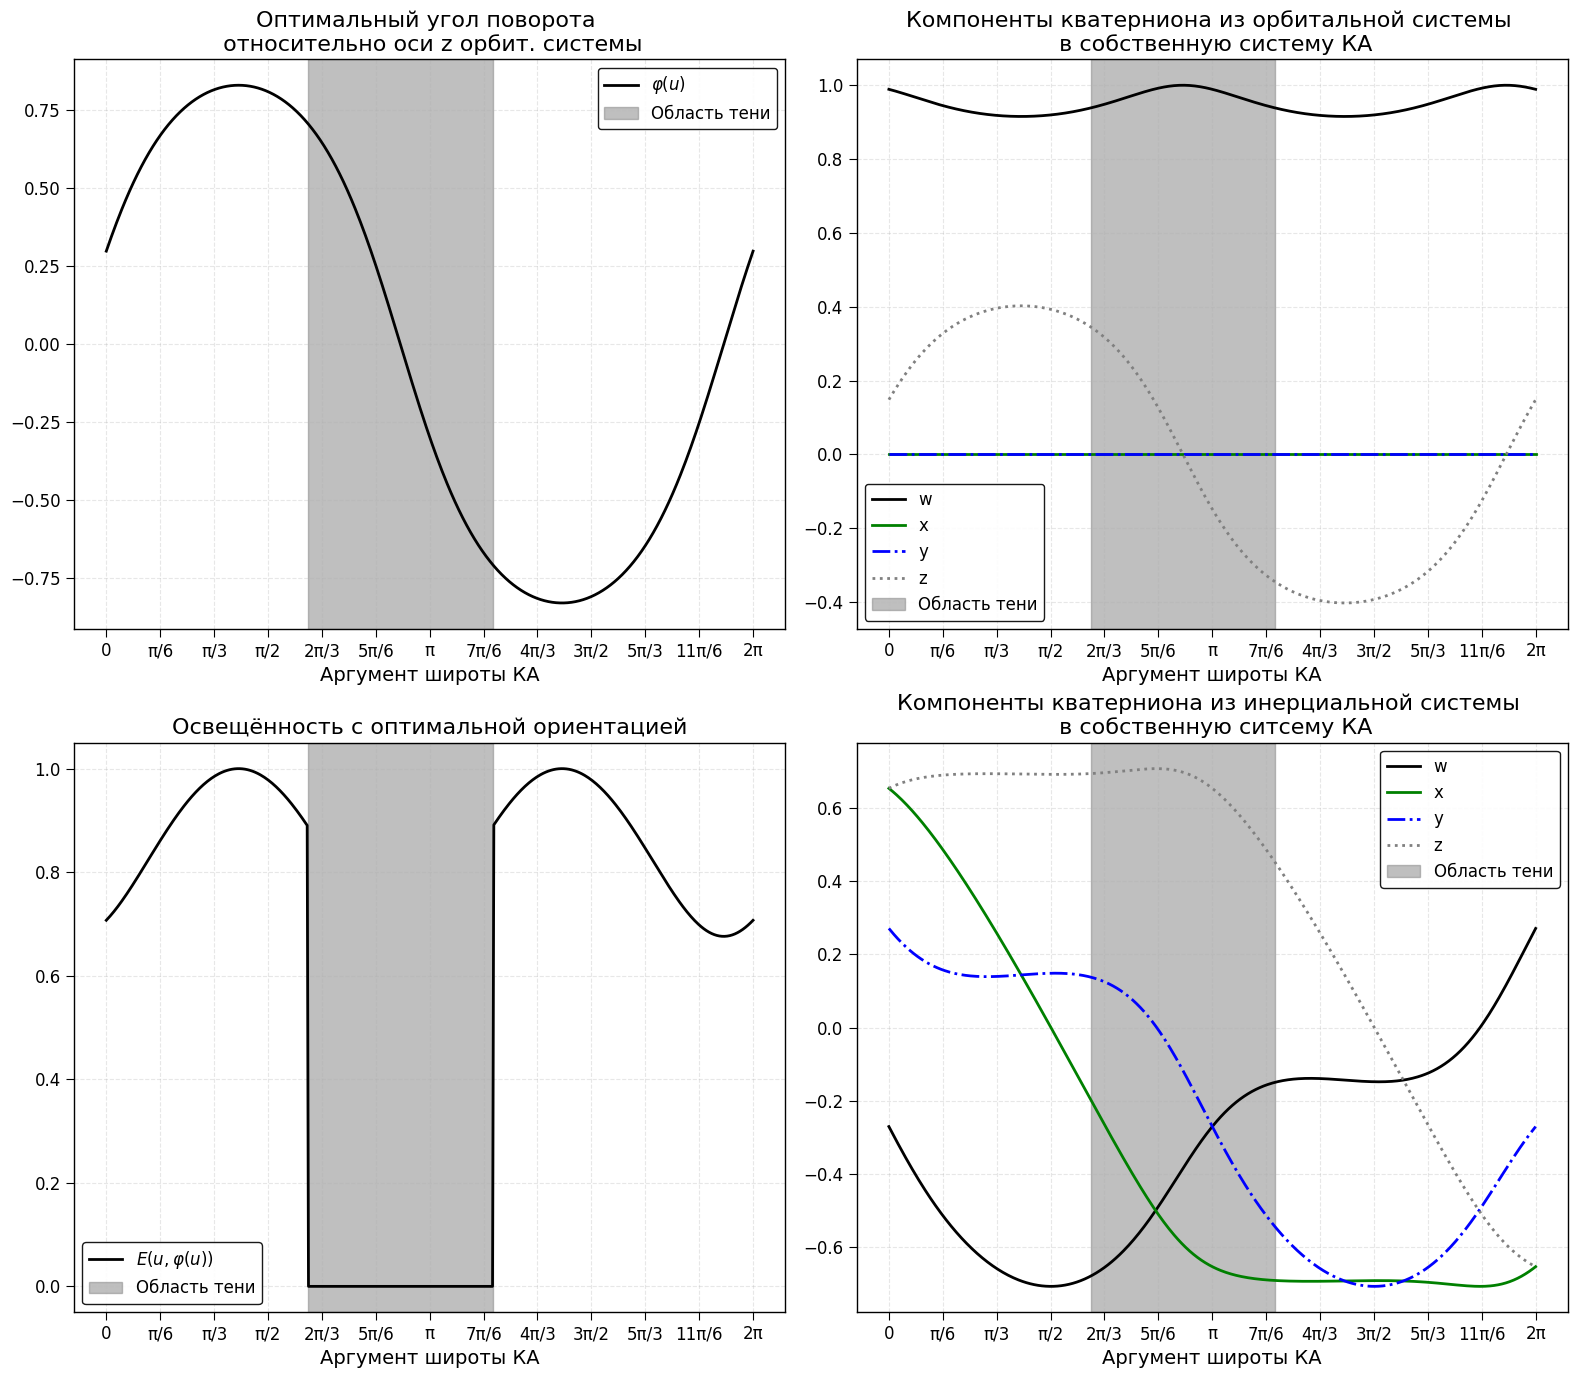

In [34]:
# Визуализация результатов

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 14))

ax[0][0].plot(u_s, phis, label=r"$\varphi(u)$")
ax[0][0].set_title("Оптимальный угол поворота \n относительно оси z орбит. системы")

ax[1][0].plot(u_s, shadow * illuminance, label=r'$E(u, \varphi(u))$')
ax[1][0].set_title("Освещённость с оптимальной ориентацией")

ax[0][1].plot(u_s, q_o2sc, label=('w', 'x', 'y', 'z'))
ax[0][1].set_title("Компоненты кватерниона из орбитальной системы \n в собственную систему КА")

ax[1][1].plot(u_s, q_i2sc, label=('w', 'x', 'y', 'z'))
ax[1][1].set_title("Компоненты кватерниона из инерциальной системы \n в собственную ситсему КА")

for axes in ax:
    for axis in axes:
        ticks = [0, np.pi/6, np.pi/3, np.pi/2, 2*np.pi/3, 5*np.pi/6, 
         np.pi, 7*np.pi/6, 4*np.pi/3, 3*np.pi/2, 5*np.pi/3, 11*np.pi/6, 2*np.pi]
        tick_labels = ['0', 'π/6', 'π/3', 'π/2', '2π/3', '5π/6', 
               'π', '7π/6', '4π/3', '3π/2', '5π/3', '11π/6', '2π']
        axis.set_xticks(ticks, tick_labels)
        if with_shadow and u_shadow_starts != None:
            axis.axvspan(u_shadow_starts, u_shadow_ends, alpha=0.5, color='grey', label='Область тени')
        axis.grid(True)
        axis.set_xlabel("Аргумент широты КА")
        axis.legend()


plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.2) 
plt.show()
